## Install and import required libraries

In [3]:
! pip install -U textblob
! python -m textblob.download_corpora

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 59.4 MB/s eta 0:00:00
[nltk_data] Downloading package brown to /home/azureuser/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [19]:
%pip install textblob nltk


  Using cached textblob-0.19.0-py3-none-any.whl.metadata (4.4 kB)
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached regex-2024.11.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
Using cached textblob-0.19.0-py3-none-any.whl (624 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Using cached regex-2024.11.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (781 kB)
Note: you may need to restart the kernel to use updated packages.


In [20]:
from textblob import TextBlob
import nltk


In [22]:
%pip install seaborn


Note: you may need to restart the kernel to use updated packages.


In [23]:
from azureml.core import Workspace, Dataset
import nltk
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Connect to Azure ML Workspace

In [16]:
# Connect to Azure ML Workspace
subscription_id = '67ee83d8-319b-481b-a456-8c0fcc442650'
resource_group = 'rg-akash'
workspace_name = 'ml-akash'

workspace = Workspace(subscription_id, resource_group, workspace_name)

# Load Dataset from Azure
dataset = Dataset.get_by_name(workspace, name='twitter')
df = dataset.to_pandas_dataframe()

{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}


Timeout was exceeded in force_flush().
Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


In [17]:
df.head()

,Tweet_ID,Username,Text,Retweets,Likes,Timestamp
0,1,julie81,Party least receive say or single. Prevent pre...,2,25,2023-01-30 11:00:51
1,2,richardhester,Hotel still Congress may member staff. Media d...,35,29,2023-01-02 22:45:58
2,3,williamsjoseph,Nice be her debate industry that year. Film wh...,51,25,2023-01-18 11:25:19
3,4,danielsmary,Laugh explain situation career occur serious. ...,37,18,2023-04-10 22:06:29
4,5,carlwarren,Involve sense former often approach government...,27,80,2023-01-24 07:12:21


## Clean the Text Data

In [24]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

In [26]:
df['clean_text'] = df['Text'].apply(clean_text)


## Sentiment Labeling with TextBlob

In [27]:
def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['clean_text'].apply(get_sentiment)

## View sentiment distribution

/tmp/ipykernel_3047/6312405.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='Set2')


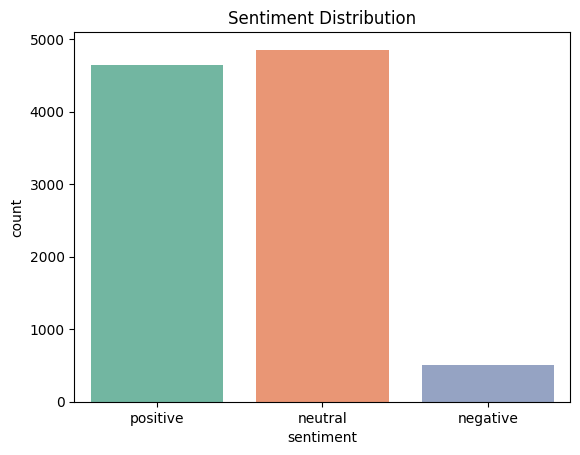

In [28]:
sns.countplot(data=df, x='sentiment', palette='Set2')
plt.title("Sentiment Distribution")
plt.show()

## Feature Extraction and Train/Test Split

In [29]:
X = df['clean_text']
y = df['sentiment']

vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)


## Train Classifier

In [30]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

## Evaluate

Classification Report:
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00        96
     neutral       0.82      0.90      0.86       990
    positive       0.89      0.89      0.89       914

    accuracy                           0.85      2000
   macro avg       0.57      0.60      0.58      2000
weighted avg       0.81      0.85      0.83      2000



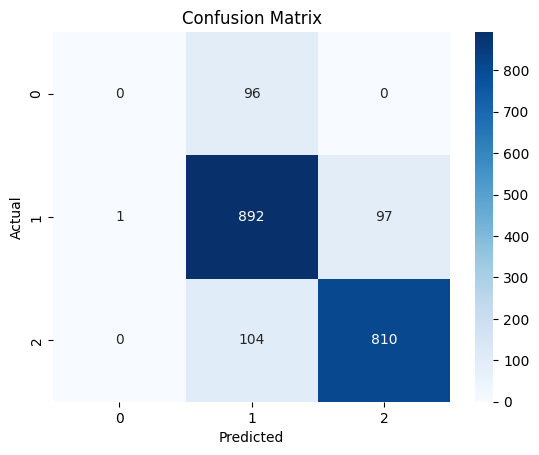

In [31]:
y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

What does this tell us?

- The model is very good at detecting neutral and positive sentiments (F1-scores ~0.86 and 0.89).

- The model is failing completely on negative sentiment — precision, recall, and F1 are all 0.
 
- This suggests class imbalance or difficulty recognizing negative examples.
 
- Overall accuracy looks okay at 85%, but accuracy can be misleading with imbalanced classes.

In [35]:
df.head()

,Tweet_ID,Username,Text,Retweets,Likes,Timestamp,clean_text,sentiment
0,1,julie81,Party least receive say or single. Prevent pre...,2,25,2023-01-30 11:00:51,party least receive say or single prevent prev...,positive
1,2,richardhester,Hotel still Congress may member staff. Media d...,35,29,2023-01-02 22:45:58,hotel still congress may member staff media dr...,positive
2,3,williamsjoseph,Nice be her debate industry that year. Film wh...,51,25,2023-01-18 11:25:19,nice be her debate industry that year film whe...,positive
3,4,danielsmary,Laugh explain situation career occur serious. ...,37,18,2023-04-10 22:06:29,laugh explain situation career occur serious f...,neutral
4,5,carlwarren,Involve sense former often approach government...,27,80,2023-01-24 07:12:21,involve sense former often approach government...,neutral


In [39]:
%pip install pyodbc


Note: you may need to restart the kernel to use updated packages.


In [41]:
import pandas as pd
import pyodbc


##  Azure SQL connection string

In [42]:
server = 'svr-akash.database.windows.net'
database = 'sql-akash'
username = 'adminakash'
password = 'Ak@s#.2809'  

conn_str = f'DRIVER={{ODBC Driver 17 for SQL Server}};' \
           f'SERVER={server};DATABASE={database};UID={username};PWD={password}'


## Connect and insert

In [44]:
conn = pyodbc.connect(conn_str)
cursor = conn.cursor()

# Create the table if it doesn't exist
cursor.execute("""
IF OBJECT_ID('dbo.SentimentTweets', 'U') IS NULL
CREATE TABLE dbo.SentimentTweets (
    Tweet_ID INT,
    Username NVARCHAR(100),
    Text NVARCHAR(MAX),
    Retweets INT,
    Likes INT,
    Timestamp DATETIME,
    clean_text NVARCHAR(MAX),
    sentiment NVARCHAR(20)
)
""")
conn.commit()

# Insert data row by row
for index, row in df.iterrows():
    cursor.execute("""
        INSERT INTO dbo.SentimentTweets (Tweet_ID, Username, Text, Retweets, Likes, Timestamp, clean_text, sentiment)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?)
    """, row.Tweet_ID, row.Username, row.Text, row.Retweets, row.Likes, row.Timestamp, row.clean_text, row.sentiment)

conn.commit()
cursor.close()
conn.close()
